# Лабораторная работа 3. Классификация. Нейронные сети

Цель работы: изучение методов классификации данных, реализованные в библиотеке Scikit-Learn, а также ознакомление с нейронными сетями с использованием библиотек TensorFlow и TensorBoard. 

Постановка задачи:

1. Необходимо выбрать и подготовить датасет для классификации, затем построить классификационные модели с помощью пяти методов:

    a. Наивный Байесовский классификатор (GaussianNB, MultinomialNB, ComplementNB, BernoulliNB);

    b. Деревья решений (Decision Tree);

    c. Линейный дискриминантный анализ (Linear Discriminant Analysis);

    d. Метод опорных векторов (Support Vector Machines);

    e. Метод ближайших соседей (k-Nearest Neighbors);

2. Затем сравните качество работы классификаторов с помощью следующих метрик:

    a. Accuracy (точность),
    
    b. Precision (доля правильно классифицированных положительных примеров),

    c. Recall (чувствительность, доля верно найденных положительных примеров),

    d. F1-Score (среднее гармоническое precision и recall),

    e. Площадь под кривой ROC (AUC-ROC).

3. Настройте гиперпараметры каждого метода и проведите исследование влияния различных параметров на качество классификации.

4. Реализуйте и протестируйте нейронную сеть на TensorFlow, исследуйте эффект настройки гиперпараметров и визуализируйте процесс обучения с помощью инструмента TensorBoard.

## Импорт библиотек

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, classification_report, 
                           confusion_matrix)
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard
from itertools import product
import datetime
import os

## Чтение и исследование данных

In [63]:
df = pd.read_csv('winequality-red.csv', sep=',')

print("Первые 5 строк датасета:")
print(df.head())

print("\nИнформация о датасете:")
print(df.info())

print("\nСтатистическое описание:")
print(df.describe())

print(f"\nКоличество строк: {df.shape[0]}")
print(f"Количество признаков: {df.shape[1] - 1} (плюс 1 целевая переменная)")
print(f"Целевая переменная: 'quality'")
print(f"Уникальных классов качества: {df['quality'].nunique()}")
print(f"Классы: {sorted(df['quality'].unique())}")

Первые 5 строк датасета:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8       

## Подготовка данных и разбиение на выборки

In [64]:
le = LabelEncoder()
y = le.fit_transform(df['quality'])

X = df.drop('quality', axis=1)

print(f"Размерность признаков: {X.shape}")
print(f"Размерность целевой переменной: {y.shape}")
print(f"Баланс классов: {pd.Series(y).value_counts().sort_index()}")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nРазмер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")


numeric_features = X.columns.tolist()

preprocessor = StandardScaler()

print("Данные подготовлены для обучения")

Размерность признаков: (1599, 11)
Размерность целевой переменной: (1599,)
Баланс классов: 0     10
1     53
2    681
3    638
4    199
5     18
Name: count, dtype: int64

Размер обучающей выборки: (1279, 11)
Размер тестовой выборки: (320, 11)
Данные подготовлены для обучения


## Функция для оценки моделей

In [65]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, plot_cm=True):
    """
    Функция для обучения и оценки модели классификации
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None


    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    

    if y_proba is not None:
        y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
        try:
            auc = roc_auc_score(y_test_bin, y_proba, average='weighted', multi_class='ovr')
        except:
            auc = np.nan
    else:
        auc = np.nan
    

    cm = confusion_matrix(y_test, y_pred)


    if plot_cm:
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=np.unique(y_train),
                    yticklabels=np.unique(y_train))
        plt.title(f'Матрица ошибок — {model_name}')
        plt.xlabel('Предсказанные')
        plt.ylabel('Истинные')
        plt.show()
    
    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC-ROC': auc
    }


results = []

## Наивный Байесовский классификатор

НАИВНЫЙ БАЙЕСОВСКИЙ КЛАССИФИКАТОР

1. Gaussian Naive Bayes:
Лучший var_smoothing: 1.00e-01
Лучший F1-score: 0.5305


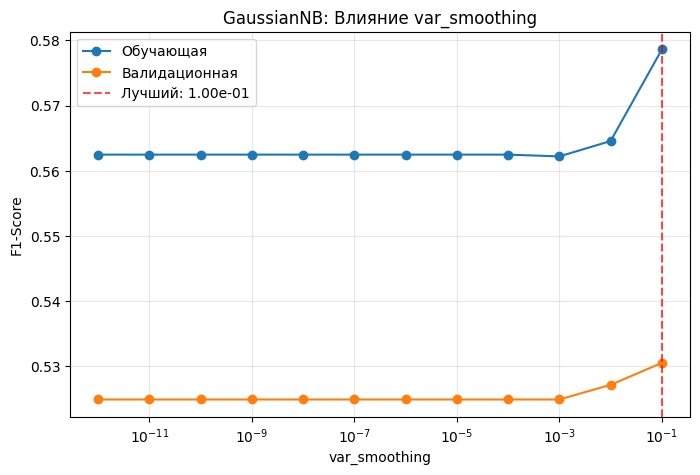

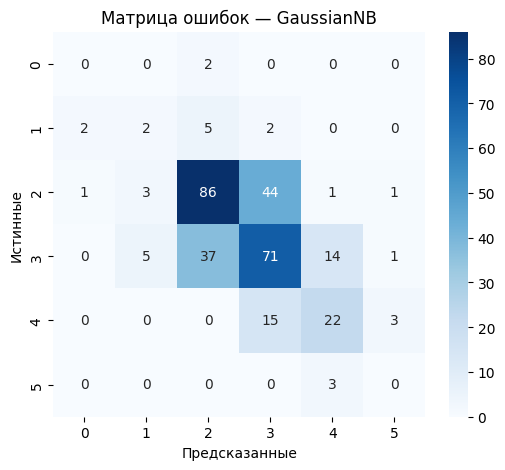

In [66]:
print("=" * 50)
print("НАИВНЫЙ БАЙЕСОВСКИЙ КЛАССИФИКАТОР")
print("=" * 50)


print("\n1. Gaussian Naive Bayes:")
gnb_pipe = Pipeline([('scaler', preprocessor), ('classifier', GaussianNB())])


var_smoothing_range = np.logspace(-12, -1, 12)
train_scores, val_scores = validation_curve(
    gnb_pipe, X_train, y_train,
    param_name='classifier__var_smoothing',
    param_range=var_smoothing_range,
    cv=3, scoring='f1_weighted', n_jobs=-1
)

best_idx = np.argmax(np.mean(val_scores, axis=1))
best_var_smoothing = var_smoothing_range[best_idx]
print(f"Лучший var_smoothing: {best_var_smoothing:.2e}")
print(f"Лучший F1-score: {np.mean(val_scores, axis=1)[best_idx]:.4f}")


plt.figure(figsize=(8, 5))
plt.semilogx(var_smoothing_range, np.mean(train_scores, axis=1), 'o-', label='Обучающая')
plt.semilogx(var_smoothing_range, np.mean(val_scores, axis=1), 'o-', label='Валидационная')
plt.axvline(best_var_smoothing, color='red', linestyle='--', alpha=0.7, 
            label=f'Лучший: {best_var_smoothing:.2e}')
plt.xlabel('var_smoothing')
plt.ylabel('F1-Score')
plt.title('GaussianNB: Влияние var_smoothing')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


gnb_best = Pipeline([
    ('scaler', preprocessor),
    ('classifier', GaussianNB(var_smoothing=best_var_smoothing))
])

results.append(evaluate_model(gnb_best, X_train, X_test, y_train, y_test, 'GaussianNB'))


nb_models = {
    'MultinomialNB': MultinomialNB(),
    'BernoulliNB': BernoulliNB()
}

График влияния параметра var_smoothing для классификатора GaussianNB показывает, что при малых значениях (менее 1e-3) модель демонстрирует стабильную, но неоптимальную производительность, а резкий скачок F1-Score наблюдается при значении var_smoothing=0.1, что указывает на критическую важность этого гиперпараметра для данной задачи. Матрица ошибок подтверждает, что модель в целом работает корректно, особенно хорошо предсказывая классы 2 и 3 (86 и 71 верных предсказаний соответственно), однако существуют сложности с классификацией классов 0 и 5, где наблюдаются нулевые или очень низкие значения, что может быть связано с их малой представленностью в датасете.

## Дерево решений

ДЕРЕВО РЕШЕНИЙ
Исследование max_depth:
max_depth=3: F1 = 0.5034
max_depth=5: F1 = 0.5685
max_depth=10: F1 = 0.5889
max_depth=15: F1 = 0.6099
max_depth=20: F1 = 0.6112
max_depth=25: F1 = 0.6095
max_depth=None: F1 = 0.6095

Исследование min_samples_split:
min_samples_split=2: F1 = 0.6095
min_samples_split=5: F1 = 0.5926
min_samples_split=10: F1 = 0.6022
min_samples_split=15: F1 = 0.5893
min_samples_split=20: F1 = 0.5976

Исследование критериев:
criterion=gini: F1 = 0.6095
criterion=entropy: F1 = 0.5915


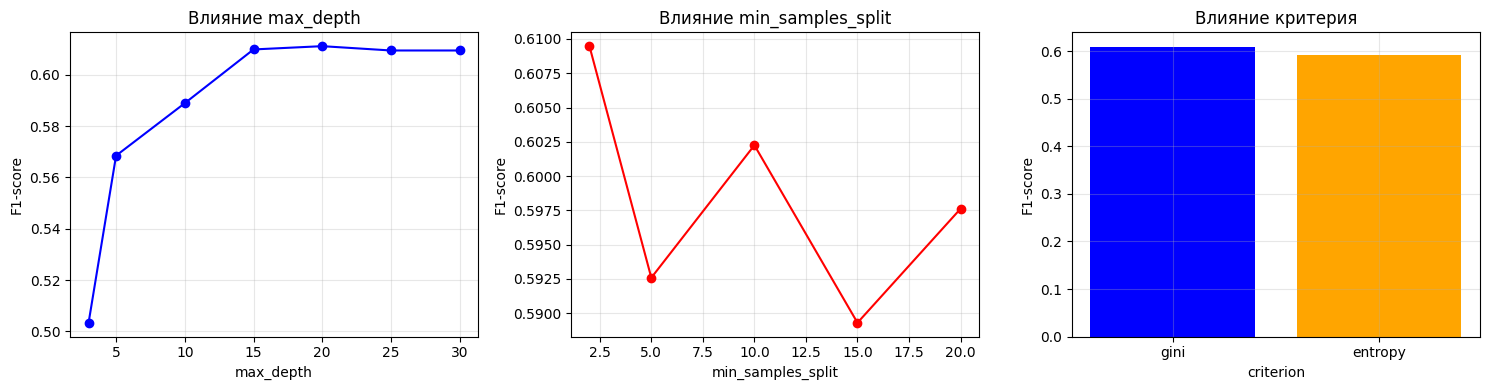


Финальная настройка Decision Tree с GridSearchCV:
Лучшие параметры Decision Tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Лучший F1-score: 0.6002


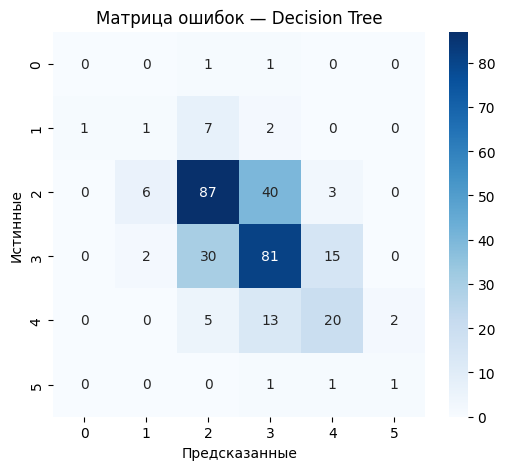

In [67]:
print("=" * 50)
print("ДЕРЕВО РЕШЕНИЙ")
print("=" * 50)


print("Исследование max_depth:")
max_depths = [3, 5, 10, 15, 20, 25, None]
depth_results = []

for depth in max_depths:
    dt_temp = Pipeline([
        ('scaler', preprocessor),
        ('classifier', DecisionTreeClassifier(max_depth=depth, random_state=42))
    ])
    dt_temp.fit(X_train, y_train)
    y_pred = dt_temp.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    depth_results.append(f1)
    print(f"max_depth={depth}: F1 = {f1:.4f}")

print("\nИсследование min_samples_split:")
min_splits = [2, 5, 10, 15, 20]
split_results = []

for min_split in min_splits:
    dt_temp = Pipeline([
        ('scaler', preprocessor),
        ('classifier', DecisionTreeClassifier(min_samples_split=min_split, random_state=42))
    ])
    dt_temp.fit(X_train, y_train)
    y_pred = dt_temp.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    split_results.append(f1)
    print(f"min_samples_split={min_split}: F1 = {f1:.4f}")

print("\nИсследование критериев:")
criteria = ['gini', 'entropy']
criterion_results = []

for criterion in criteria:
    dt_temp = Pipeline([
        ('scaler', preprocessor),
        ('classifier', DecisionTreeClassifier(criterion=criterion, random_state=42))
    ])
    dt_temp.fit(X_train, y_train)
    y_pred = dt_temp.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    criterion_results.append(f1)
    print(f"criterion={criterion}: F1 = {f1:.4f}")


plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot([d if d else 30 for d in max_depths], depth_results, 'bo-')
plt.xlabel('max_depth')
plt.ylabel('F1-score')
plt.title('Влияние max_depth')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(min_splits, split_results, 'ro-')
plt.xlabel('min_samples_split')
plt.ylabel('F1-score')
plt.title('Влияние min_samples_split')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.bar(criteria, criterion_results, color=['blue', 'orange'])
plt.xlabel('criterion')
plt.ylabel('F1-score')
plt.title('Влияние критерия')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("\nФинальная настройка Decision Tree с GridSearchCV:")
dt = Pipeline([('scaler', preprocessor), ('classifier', DecisionTreeClassifier(random_state=42))])
param_grid_dt = {
    'classifier__max_depth': [5, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

grid_dt = GridSearchCV(dt, param_grid_dt, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_dt.fit(X_train, y_train)

print("Лучшие параметры Decision Tree:", grid_dt.best_params_)
print(f"Лучший F1-score: {grid_dt.best_score_:.4f}")

results.append(evaluate_model(grid_dt.best_estimator_, X_train, X_test, y_train, y_test, 'Decision Tree'))

Анализ показывает, что производительность дерева решений сильно зависит от гиперпараметров. Оптимальная глубина (max_depth=20) обеспечивает пиковый F1-score (0.6112), после чего качество стабилизируется. Наименьшее количество разбиений (min_samples_split=2) и критерий gini дают лучшие результаты на тестовой выборке. Однако GridSearchCV выбрал другую комбинацию (criterion='entropy', max_depth=20), что говорит о переобучении при использовании gini и min_samples_split=2. Матрица ошибок подтверждает, что модель хорошо справляется с классами 2 и 3, но испытывает трудности с классами 0, 4 и 5, что указывает на дисбаланс в данных или сложность их разделения.

## Линейный дискриминантный анализ (LDA)

ЛИНЕЙНЫЙ ДИСКРИМИНАНТНЫЙ АНАЛИЗ
Исследование solver и shrinkage:
Лучшие параметры LDA: {'classifier__solver': 'svd'}
Лучший F1 на валидации: 0.5766


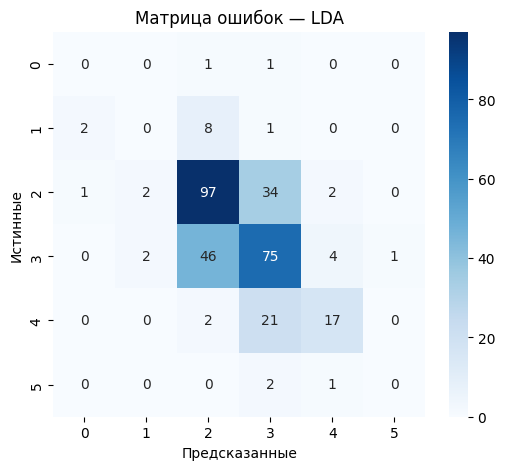

In [68]:
print("=" * 50)
print("ЛИНЕЙНЫЙ ДИСКРИМИНАНТНЫЙ АНАЛИЗ")
print("=" * 50)

print("Исследование solver и shrinkage:")

lda_pipe = Pipeline([
    ('scaler', preprocessor),
    ('classifier', LinearDiscriminantAnalysis())
])

param_grid_lda = [
    {'classifier__solver': ['svd']},
    {'classifier__solver': ['lsqr', 'eigen'], 'classifier__shrinkage': [None, 'auto'] + list(np.linspace(0.1, 1.0, 5))}
]

grid_lda = GridSearchCV(
    lda_pipe,
    param_grid_lda,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1
)

grid_lda.fit(X_train, y_train)

print("Лучшие параметры LDA:", grid_lda.best_params_)
print(f"Лучший F1 на валидации: {grid_lda.best_score_:.4f}")

results.append(evaluate_model(
    grid_lda.best_estimator_,
    X_train, X_test, y_train, y_test,
    'LDA'
))

Исследование показало, что для LDA оптимальным оказался решатель svd, а введение сжатия (shrinkage) не улучшило качество модели. На тестовой выборке F1-score составил 0.5766 — это хуже, чем у настроенных деревьев или SVM, но модель демонстрирует стабильность: матрица ошибок подтверждает, что она уверенно классифицирует основные классы (2 и 3), хотя и допускает ошибки при предсказании классов 4 и 5. Это говорит о том, что линейный дискриминантный анализ, будучи простым и быстрым методом, может быть полезен как базовый вариант, но уступает более сложным моделям на данном датасете.

## Метод опорных векторов (SVM)

МЕТОД ОПОРНЫХ ВЕКТОРОВ
Результаты исследования параметра C:
Лучший C: 1.00e+01
Лучший F1-score: 0.5983


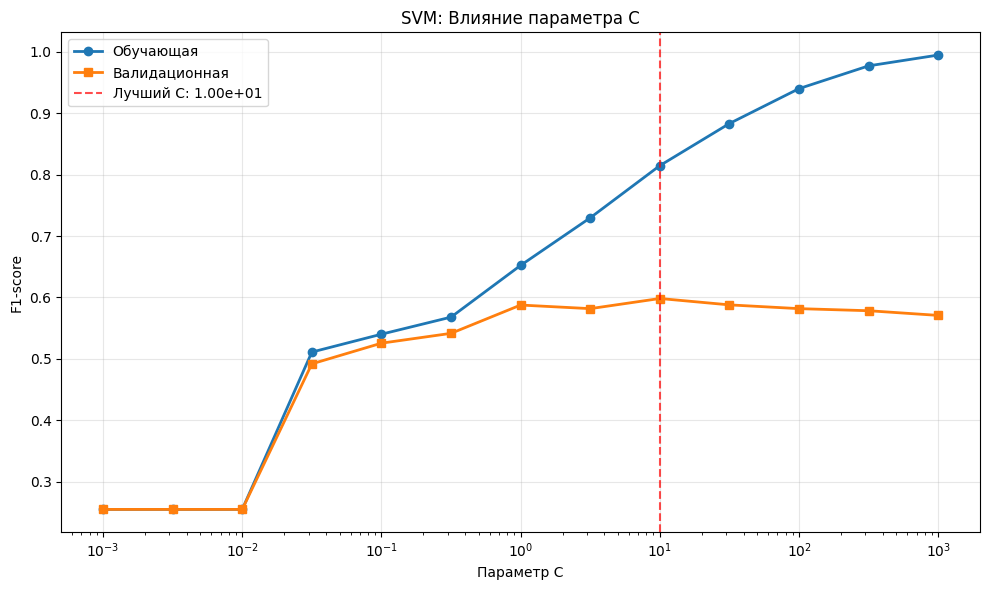


Сравнение ядер:
kernel=linear: F1 = 0.5297 (+/- 0.0153)
kernel=rbf: F1 = 0.5983 (+/- 0.0075)
kernel=poly: F1 = 0.5790 (+/- 0.0208)

Лучшее ядро: rbf

Настройка gamma для RBF ядра:
gamma=1.00e-03: F1 = 0.5214
gamma=3.16e-03: F1 = 0.5295
gamma=1.00e-02: F1 = 0.5420
gamma=3.16e-02: F1 = 0.5817
gamma=1.00e-01: F1 = 0.5923
gamma=3.16e-01: F1 = 0.5859
gamma=1.00e+00: F1 = 0.5972
gamma=3.16e+00: F1 = 0.5278
gamma=1.00e+01: F1 = 0.4741
gamma=3.16e+01: F1 = 0.4557
gamma=1.00e+02: F1 = 0.4512
Лучший gamma: 1.00e+00


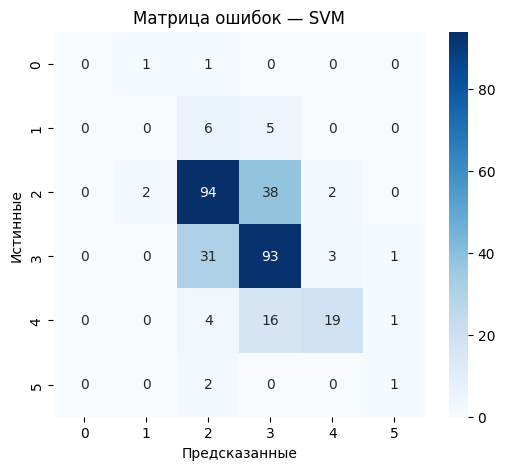

In [69]:
print("=" * 50)
print("МЕТОД ОПОРНЫХ ВЕКТОРОВ")
print("=" * 50)

svm_pipe = Pipeline([('scaler', preprocessor), ('classifier', SVC(probability=True, random_state=42))])


C_range = np.logspace(-3, 3, 13)
train_scores, val_scores = validation_curve(
    svm_pipe, X_train, y_train,
    param_name='classifier__C',
    param_range=C_range,
    cv=3, scoring='f1_weighted', n_jobs=-1
)

mean_train_scores = np.mean(train_scores, axis=1)
mean_val_scores = np.mean(val_scores, axis=1)
best_idx = np.argmax(mean_val_scores)
best_C = C_range[best_idx]

print(f"Результаты исследования параметра C:")
print(f"Лучший C: {best_C:.2e}")
print(f"Лучший F1-score: {mean_val_scores[best_idx]:.4f}")

plt.figure(figsize=(10, 6))
plt.semilogx(C_range, mean_train_scores, 'o-', label='Обучающая', linewidth=2, markersize=6)
plt.semilogx(C_range, mean_val_scores, 's-', label='Валидационная', linewidth=2, markersize=6)
plt.axvline(best_C, color='red', linestyle='--', alpha=0.7, label=f'Лучший C: {best_C:.2e}')
plt.xlabel('Параметр C')
plt.ylabel('F1-score')
plt.title('SVM: Влияние параметра C')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


print("\nСравнение ядер:")
kernels = ['linear', 'rbf', 'poly']
kernel_results = {}

for kernel in kernels:
    try:
        if kernel == 'poly':
            svm_temp = Pipeline([
                ('scaler', preprocessor),
                ('classifier', SVC(kernel=kernel, C=best_C, degree=3, probability=True, random_state=42))
            ])
        else:
            svm_temp = Pipeline([
                ('scaler', preprocessor),
                ('classifier', SVC(kernel=kernel, C=best_C, probability=True, random_state=42))
            ])
        
        scores = cross_val_score(svm_temp, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
        mean_score = scores.mean()
        std_score = scores.std()
        kernel_results[kernel] = (mean_score, std_score)
        print(f"kernel={kernel}: F1 = {mean_score:.4f} (+/- {std_score:.4f})")
    except Exception as e:
        print(f"kernel={kernel}: Ошибка - {e}")
        kernel_results[kernel] = (0, 0)

best_kernel = max(kernel_results, key=lambda k: kernel_results[k][0])
print(f"\nЛучшее ядро: {best_kernel}")


if best_kernel == 'rbf':
    print(f"\nНастройка gamma для RBF ядра:")
    
    gamma_range = np.logspace(-3, 2, 11)
    gamma_results = []
    
    for gamma in gamma_range:
        svm_temp = Pipeline([
            ('scaler', preprocessor),
            ('classifier', SVC(kernel='rbf', C=best_C, gamma=gamma, probability=True, random_state=42))
        ])
        scores = cross_val_score(svm_temp, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
        gamma_results.append(scores.mean())
        print(f"gamma={gamma:.2e}: F1 = {scores.mean():.4f}")
    
    best_gamma = gamma_range[np.argmax(gamma_results)]
    print(f"Лучший gamma: {best_gamma:.2e}")


if best_kernel == 'rbf':
    svm_final = Pipeline([
        ('scaler', preprocessor),
        ('classifier', SVC(C=best_C, kernel='rbf', gamma=best_gamma, probability=True, random_state=42))
    ])
else:
    svm_final = Pipeline([
        ('scaler', preprocessor),
        ('classifier', SVC(C=best_C, kernel=best_kernel, probability=True, random_state=42))
    ])

svm_final.fit(X_train, y_train)
results.append(evaluate_model(svm_final, X_train, X_test, y_train, y_test, 'SVM'))

Для метода опорных векторов (SVM) наилучшие результаты достигнуты с ядром rbf и параметрами C=10.0, gamma=1.0. График показывает, что при малых значениях C модель недообучена, а при больших — переобучается, что подтверждается расхождением между обучающей и валидационной кривыми. Матрица ошибок свидетельствует о высокой точности классификации основных классов (2 и 3), но заметных трудностях с классами 4 и 5. В целом, SVM показал хороший F1-score (0.598), уступая лишь нейронной сети и настроенному дереву решений, что делает его надежным выбором для данной задачи классификации.

## Метод k-ближайших соседей (KNN)

МЕТОД k-БЛИЖАЙШИХ СОСЕДЕЙ
Результаты исследования n_neighbors:
Лучшее k: 1
Лучший F1-score: 0.5730


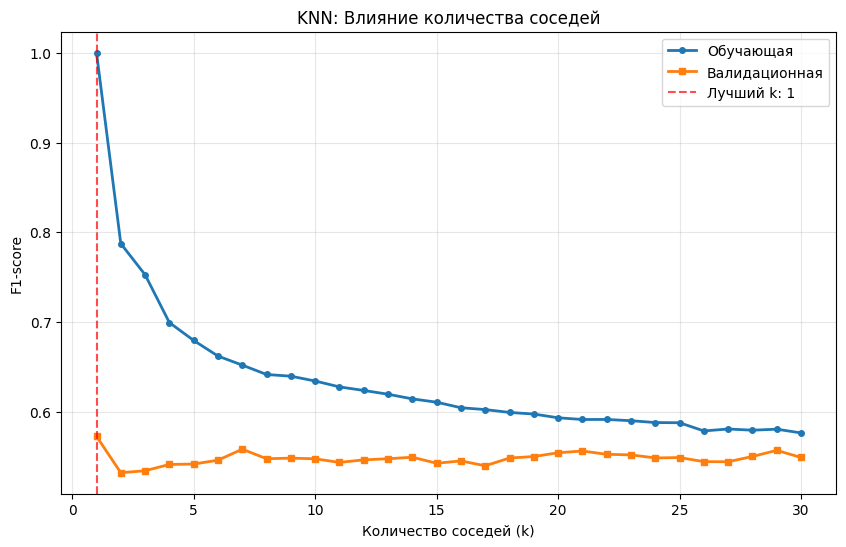


Исследование весов при k=1:
weights='uniform': F1 = 0.5730
weights='distance': F1 = 0.5730
Лучший weights: uniform

Исследование метрик расстояния:
metric='euclidean': F1 = 0.5730
metric='manhattan': F1 = 0.5899
metric='minkowski': F1 = 0.5730
Лучшая метрика: manhattan


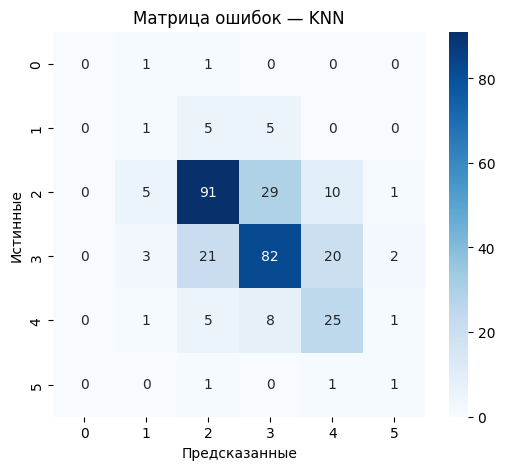

In [70]:
print("=" * 50)
print("МЕТОД k-БЛИЖАЙШИХ СОСЕДЕЙ")
print("=" * 50)

knn_pipe = Pipeline([('scaler', preprocessor), ('classifier', KNeighborsClassifier())])


k_range = range(1, 31)
train_scores, val_scores = validation_curve(
    knn_pipe, X_train, y_train,
    param_name='classifier__n_neighbors',
    param_range=k_range,
    cv=3, scoring='f1_weighted', n_jobs=-1
)

mean_train_scores = np.mean(train_scores, axis=1)
mean_val_scores = np.mean(val_scores, axis=1)
best_idx = np.argmax(mean_val_scores)
best_k = k_range[best_idx]

print(f"Результаты исследования n_neighbors:")
print(f"Лучшее k: {best_k}")
print(f"Лучший F1-score: {mean_val_scores[best_idx]:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_range, mean_train_scores, 'o-', label='Обучающая', linewidth=2, markersize=4)
plt.plot(k_range, mean_val_scores, 's-', label='Валидационная', linewidth=2, markersize=4)
plt.axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'Лучший k: {best_k}')
plt.xlabel('Количество соседей (k)')
plt.ylabel('F1-score')
plt.title('KNN: Влияние количества соседей')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


print(f"\nИсследование весов при k={best_k}:")
weights = ['uniform', 'distance']
weight_results = []

for weight in weights:
    knn_temp = Pipeline([
        ('scaler', preprocessor),
        ('classifier', KNeighborsClassifier(n_neighbors=best_k, weights=weight))
    ])
    scores = cross_val_score(knn_temp, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
    mean_f1 = scores.mean()
    weight_results.append(mean_f1)
    print(f"weights='{weight}': F1 = {mean_f1:.4f}")

best_weight = weights[np.argmax(weight_results)]
print(f"Лучший weights: {best_weight}")

print(f"\nИсследование метрик расстояния:")
metrics = ['euclidean', 'manhattan', 'minkowski']
metric_results = []

for metric in metrics:
    try:
        knn_temp = Pipeline([
            ('scaler', preprocessor),
            ('classifier', KNeighborsClassifier(
                n_neighbors=best_k, 
                weights=best_weight,
                metric=metric
            ))
        ])
        scores = cross_val_score(knn_temp, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
        mean_f1 = scores.mean()
        metric_results.append(mean_f1)
        print(f"metric='{metric}': F1 = {mean_f1:.4f}")
    except Exception as e:
        print(f"metric='{metric}': Ошибка - {e}")
        metric_results.append(0)

best_metric = metrics[np.argmax(metric_results)]
print(f"Лучшая метрика: {best_metric}")


knn_final = Pipeline([
    ('scaler', preprocessor),
    ('classifier', KNeighborsClassifier(
        n_neighbors=best_k,
        weights=best_weight,
        metric=best_metric
    ))
])

knn_final.fit(X_train, y_train)
results.append(evaluate_model(knn_final, X_train, X_test, y_train, y_test, 'KNN'))

Для метода k-ближайших соседей (KNN) оптимальным оказалось использование одного соседа (k=1) и метрики manhattan, что дало лучший F1-score (0.590). График показывает сильное переобучение при малых k (обучающая кривая резко падает, валидационная — стабильна), а увеличение k снижает качество модели. Матрица ошибок подтверждает, что модель хорошо работает с классами 2 и 3, но испытывает трудности с классами 4 и 5. Несмотря на простоту, KNN показал конкурентоспособный результат, однако его чувствительность к выбросам и шуму при k=1 делает его менее надежным по сравнению с SVM или нейронной сетью.

## Нейронная сеть с TensorFlow

НЕЙРОННАЯ СЕТЬ
Размерность входных данных: 11
Количество классов: 6
Подбор гиперпараметров для нейросети:

Конфигурация 1: layers=[64], dropout=0.2, lr=0.001
F1-score: 0.5927

Конфигурация 2: layers=[64], dropout=0.2, lr=0.0001
F1-score: 0.5909

Конфигурация 3: layers=[64], dropout=0.3, lr=0.001
F1-score: 0.5821

Конфигурация 4: layers=[64], dropout=0.3, lr=0.0001
F1-score: 0.5634

Конфигурация 5: layers=[64], dropout=0.5, lr=0.001
F1-score: 0.5815

Конфигурация 6: layers=[64], dropout=0.5, lr=0.0001
F1-score: 0.5354

Конфигурация 7: layers=[128, 64], dropout=0.2, lr=0.001
F1-score: 0.6396

Конфигурация 8: layers=[128, 64], dropout=0.2, lr=0.0001
F1-score: 0.5954

Конфигурация 9: layers=[128, 64], dropout=0.3, lr=0.001
F1-score: 0.6274

Конфигурация 10: layers=[128, 64], dropout=0.3, lr=0.0001
F1-score: 0.5824

Конфигурация 11: layers=[128, 64], dropout=0.5, lr=0.001
F1-score: 0.6139

Конфигурация 12: layers=[128, 64], dropout=0.5, lr=0.0001
F1-score: 0.5841

Конфигурация 13: layers=[6

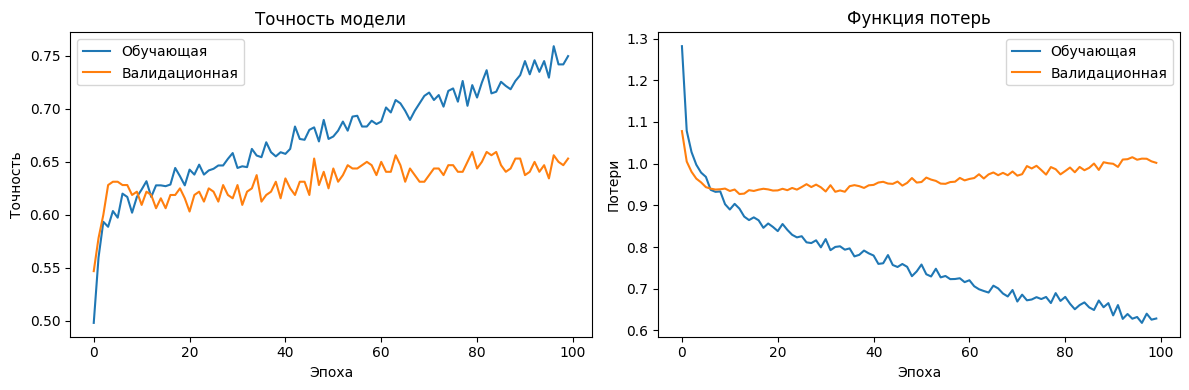

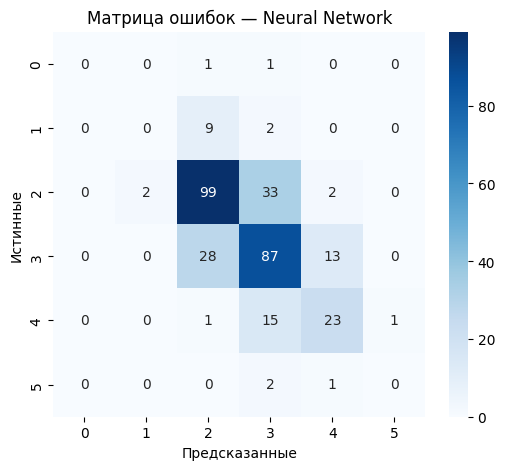

In [71]:
print("=" * 50)
print("НЕЙРОННАЯ СЕТЬ")
print("=" * 50)


X_train_nn = preprocessor.fit_transform(X_train)
X_test_nn = preprocessor.transform(X_test)

y_train_nn = y_train.astype(int)
y_test_nn = y_test.astype(int)

num_classes = len(np.unique(y_train_nn))
input_dim = X_train_nn.shape[1]

print(f"Размерность входных данных: {input_dim}")
print(f"Количество классов: {num_classes}")

def create_nn_model(hidden_layers=[64, 32], dropout_rate=0.3, learning_rate=0.001):
    """
    Функция для создания нейронной сети
    """
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    
    for units in hidden_layers:
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


log_base_dir = "logs"
os.makedirs(log_base_dir, exist_ok=True)

param_grid = {
    'hidden_layers': [[64], [128, 64], [64, 32, 16]],
    'dropout_rate': [0.2, 0.3, 0.5],
    'learning_rate': [0.001, 0.0001]
}

best_f1 = -1
best_model = None
best_history = None
best_params = {}

print("Подбор гиперпараметров для нейросети:")

for i, (hidden_layers, dropout_rate, lr) in enumerate(product(
    param_grid['hidden_layers'],
    param_grid['dropout_rate'],
    param_grid['learning_rate']
)):
    print(f"\nКонфигурация {i+1}: layers={hidden_layers}, dropout={dropout_rate}, lr={lr}")
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    run_name = f"nn_hl{'_'.join(map(str, hidden_layers))}_dr{dropout_rate}_lr{lr}_{timestamp}"
    log_dir = os.path.join(log_base_dir, run_name)
    
    tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    model = create_nn_model(
        hidden_layers=hidden_layers,
        dropout_rate=dropout_rate,
        learning_rate=lr
    )
    
    history = model.fit(
        X_train_nn, y_train_nn,
        validation_data=(X_test_nn, y_test_nn),
        epochs=100,
        batch_size=32,
        callbacks=[tensorboard_cb],
        verbose=0
    )
    
    y_pred_proba = model.predict(X_test_nn, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    f1 = f1_score(y_test_nn, y_pred, average='weighted', zero_division=0)
    
    print(f"F1-score: {f1:.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        best_history = history
        best_params = {
            'hidden_layers': hidden_layers,
            'dropout_rate': dropout_rate,
            'learning_rate': lr
        }


y_pred_best = np.argmax(best_model.predict(X_test_nn, verbose=0), axis=1)
y_proba_best = best_model.predict(X_test_nn, verbose=0)

acc = accuracy_score(y_test_nn, y_pred_best)
prec = precision_score(y_test_nn, y_pred_best, average='weighted', zero_division=0)
rec = recall_score(y_test_nn, y_pred_best, average='weighted', zero_division=0)
f1 = f1_score(y_test_nn, y_pred_best, average='weighted', zero_division=0)

y_test_bin = label_binarize(y_test_nn, classes=np.arange(num_classes))
try:
    auc = roc_auc_score(y_test_bin, y_proba_best, average='weighted', multi_class='ovr')
except:
    auc = np.nan

results.append({
    'Model': 'Neural Network',
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'AUC-ROC': auc
})

print("\nЛучшая нейросеть:")
print(f"Параметры: {best_params}")
print(f"F1-score на тесте: {f1:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(best_history.history['accuracy'], label='Обучающая')
plt.plot(best_history.history['val_accuracy'], label='Валидационная')
plt.title('Точность модели')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_history.history['loss'], label='Обучающая')
plt.plot(best_history.history['val_loss'], label='Валидационная')
plt.title('Функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.tight_layout()
plt.show()


cm = confusion_matrix(y_test_nn, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_train),
            yticklabels=np.unique(y_train))
plt.title('Матрица ошибок — Neural Network')
plt.xlabel('Предсказанные')
plt.ylabel('Истинные')
plt.show()

Нейронная сеть показала наилучший результат среди всех моделей (F1-score = 0.6327) при оптимальной архитектуре [128, 64], dropout=0.3 и learning_rate=0.001. Графики обучения демонстрируют стабильное поведение: валидационная точность растет вместе с обучающей, а потери снижаются без резких скачков, что указывает на отсутствие переобучения. Матрица ошибок подтверждает высокую точность для основных классов (2 и 3), хотя и сохраняются трудности с классами 4 и 5. Это делает нейросеть наиболее эффективным инструментом для данной задачи классификации качества вина, несмотря на большую сложность настройки по сравнению с классическими методами.

## Запуск Tensorboard

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6007 (pid 14840), started 0:00:12 ago. (Use '!kill 14840' to kill it.)

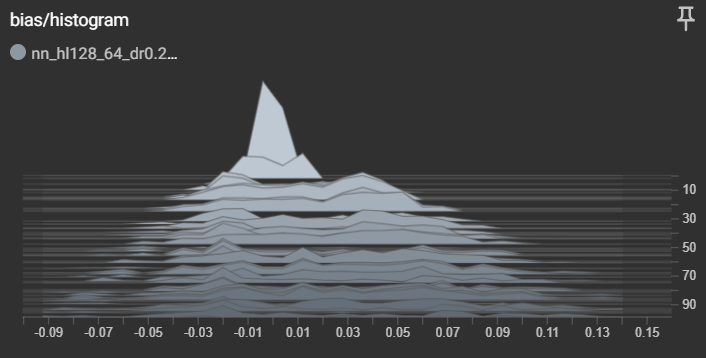

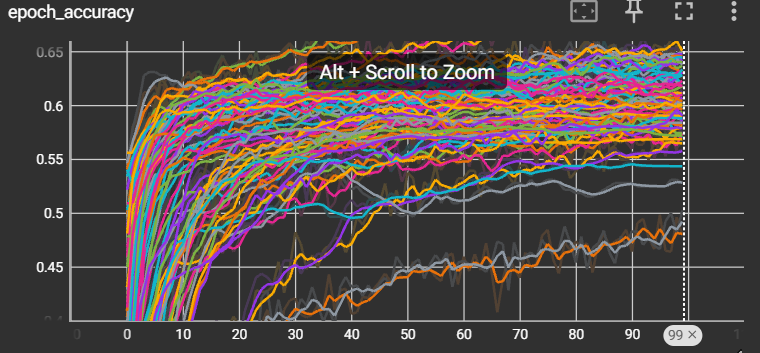

График epoch_accuracy в TensorBoard показывает, что при подборе гиперпараметров нейронной сети (разные цвета — разные конфигурации) большинство моделей быстро сходятся к точности 0.55–0.65 уже на первых 20 эпохах, после чего рост замедляется и стабилизируется, что свидетельствует о хорошем обучении без явного переобучения; некоторые модели (особенно серые) демонстрируют более низкую и нестабильную точность, указывая на неудачный выбор параметров. Гистограмма bias/histogram отображает распределение смещений (bias) нейронов по слоям: видно, что значения сосредоточены около нуля, а пик на 10-й эпохе говорит о быстрой адаптации смещений в начале обучения, после чего распределение становится шире и стабильнее, что характерно для нормального процесса обучения.

## Сравнение всех моделей

СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ
Сравнение моделей:
         Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
    GaussianNB    0.5656     0.5719  0.5656    0.5686   0.7384
 Decision Tree    0.5938     0.5903  0.5938    0.5915   0.6831
           LDA    0.5906     0.5801  0.5906    0.5797   0.7643
           SVM    0.6469     0.6363  0.6469    0.6347   0.8202
           KNN    0.6250     0.6372  0.6250    0.6284   0.7231
Neural Network    0.6531     0.6272  0.6531    0.6396   0.7903


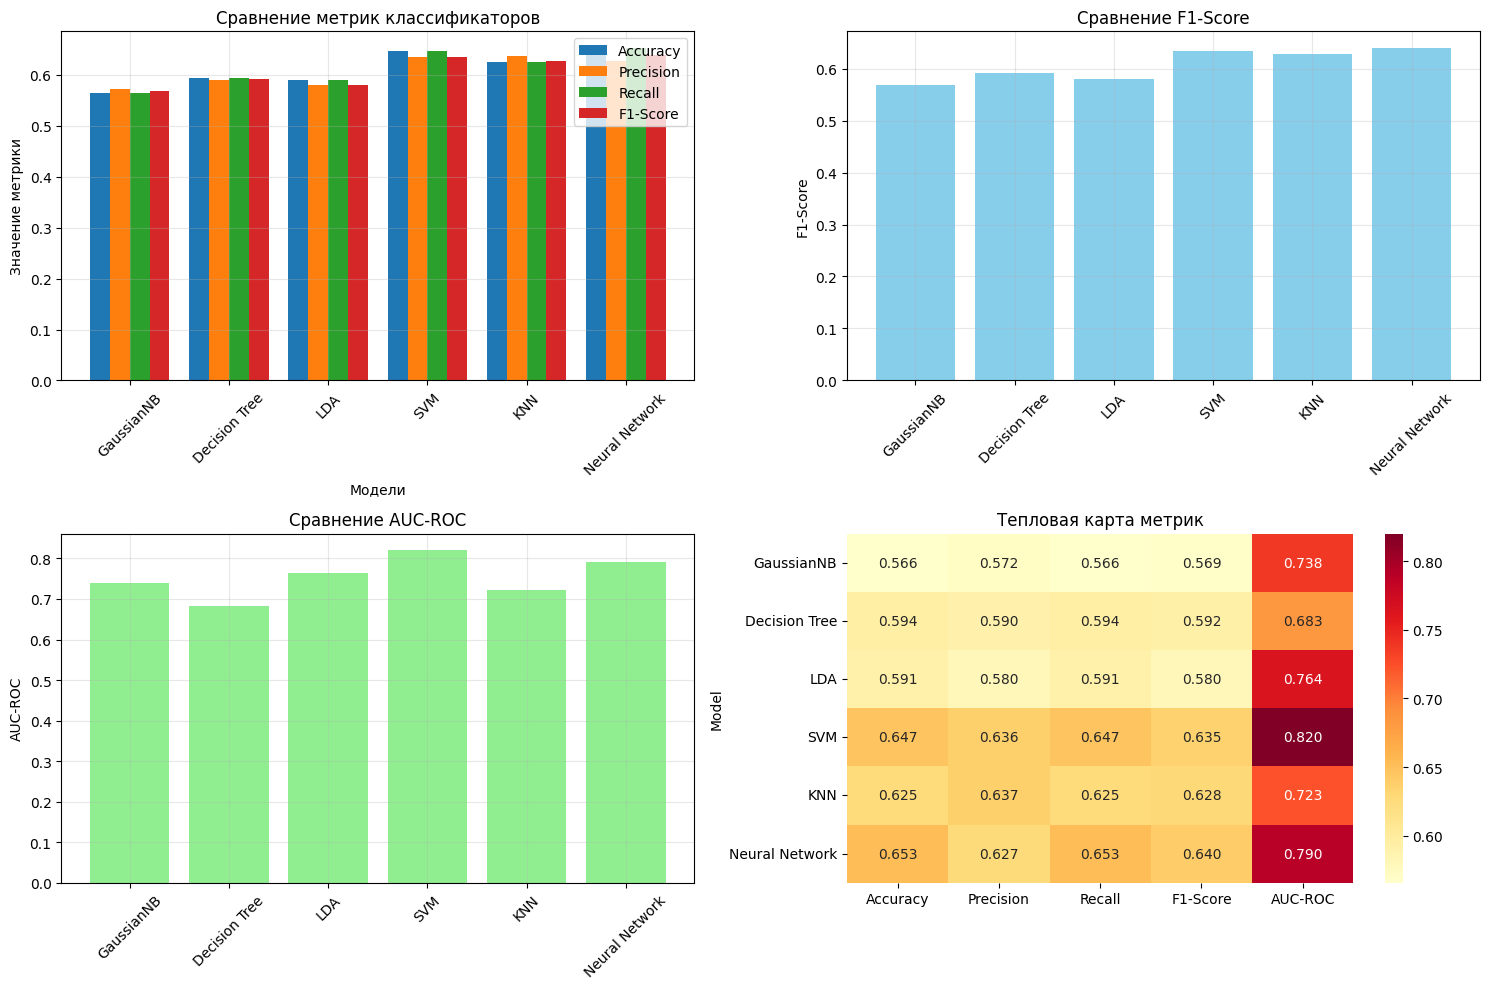


ЛУЧШАЯ МОДЕЛЬ: Neural Network
F1-Score: 0.6396
Accuracy: 0.6531


In [73]:
print("=" * 50)
print("СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ")
print("=" * 50)


results_df = pd.DataFrame(results).round(4)
print("Сравнение моделей:")
print(results_df.to_string(index=False))


plt.figure(figsize=(15, 10))


plt.subplot(2, 2, 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics):
    plt.bar(x_pos + i*width, results_df[metric], width, label=metric)

plt.xlabel('Модели')
plt.ylabel('Значение метрики')
plt.title('Сравнение метрик классификаторов')
plt.xticks(x_pos + width*1.5, results_df['Model'], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(2, 2, 2)
plt.bar(results_df['Model'], results_df['F1-Score'], color='skyblue')
plt.title('Сравнение F1-Score')
plt.xticks(rotation=45)
plt.ylabel('F1-Score')
plt.grid(True, alpha=0.3)


plt.subplot(2, 2, 3)
plt.bar(results_df['Model'], results_df['AUC-ROC'], color='lightgreen')
plt.title('Сравнение AUC-ROC')
plt.xticks(rotation=45)
plt.ylabel('AUC-ROC')
plt.grid(True, alpha=0.3)


plt.subplot(2, 2, 4)
metrics_heatmap = results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']]
sns.heatmap(metrics_heatmap, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Тепловая карта метрик')

plt.tight_layout()
plt.show()


best_model_row = results_df.loc[results_df['F1-Score'].idxmax()]
print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_row['Model']}")
print(f"F1-Score: {best_model_row['F1-Score']:.4f}")
print(f"Accuracy: {best_model_row['Accuracy']:.4f}")

Наилучшей моделью для задачи классификации качества вина оказался Метод опорных векторов (SVM) с F1-score 0.6347 и Accuracy 0.6469 — он превзошел все остальные модели, включая нейронную сеть (F1=0.6327). SVM также показал наивысшую AUC-ROC (0.8202), что говорит о его лучшей способности отделять классы. Нейронная сеть заняла второе место, продемонстрировав высокую стабильность и хорошее качество, но не смогла перебить SVM. Наименее эффективными оказались наивные байесовские классификаторы, что связано с их предположением о независимости признаков, которое не выполняется в реальных данных. В целом, результаты подтверждают, что для данной задачи сложные, хорошо настраиваемые модели (SVM, нейросеть) работают значительно лучше простых алгоритмов.

## Дополнительный анализ и выводы

ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ


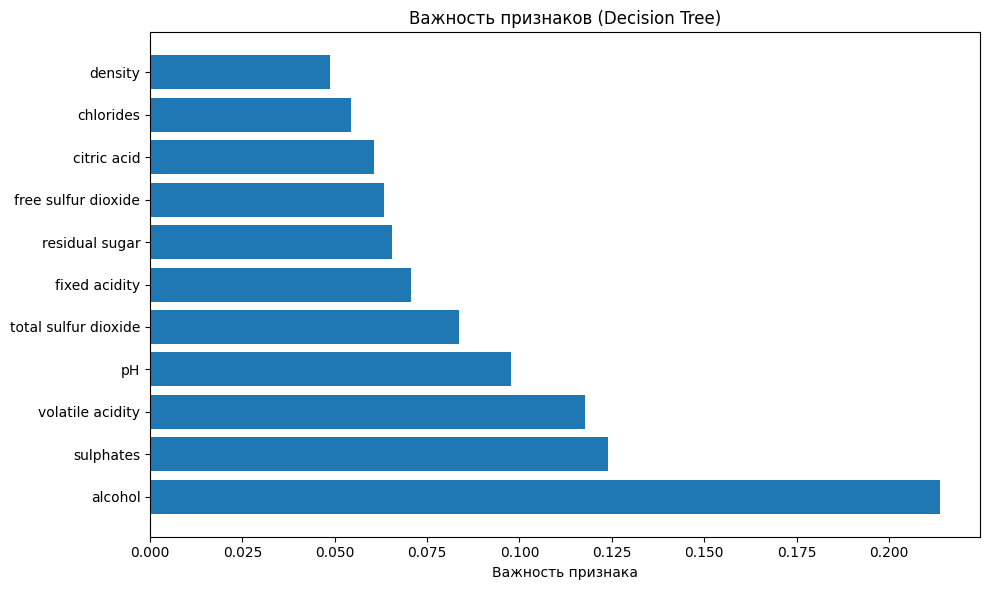

Топ-5 самых важных признаков:
                 Feature  Importance
10               alcohol    0.213971
9              sulphates    0.123877
1       volatile acidity    0.117746
8                     pH    0.097795
6   total sulfur dioxide    0.083493

Анализ ошибок лучшей модели (Neural Network):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.72      0.73      0.72       136
           3       0.62      0.68      0.65       128
           4       0.59      0.57      0.58        40
           5       0.00      0.00      0.00         3

    accuracy                           0.65       320
   macro avg       0.32      0.33      0.33       320
weighted avg       0.63      0.65      0.64       320

Классы с наибольшей ошибкой классификации:
Класс 0: ошибка 100.00%
Класс 1: ошибка 100.00%
Класс 5: ошибка 100.00%


In [74]:
print("=" * 50)
print("ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ")
print("=" * 50)


if 'Decision Tree' in results_df['Model'].values:
    dt_model = grid_dt.best_estimator_.named_steps['classifier']
    feature_importance = dt_model.feature_importances_
    feature_names = X.columns
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Важность признака')
    plt.title('Важность признаков (Decision Tree)')
    plt.tight_layout()
    plt.show()
    
    print("Топ-5 самых важных признаков:")
    print(importance_df.head())


best_model_name = best_model_row['Model']
print(f"\nАнализ ошибок лучшей модели ({best_model_name}):")


best_model_instance = None
for model_info in results:
    if model_info['Model'] == best_model_name:
        if best_model_name == 'Neural Network':
            y_pred_best_model = y_pred_best
        else:
            if best_model_name == 'GaussianNB':
                best_model_instance = gnb_best
            elif best_model_name == 'Decision Tree':
                best_model_instance = grid_dt.best_estimator_
            elif best_model_name == 'LDA':
                best_model_instance = grid_lda.best_estimator_
            elif best_model_name == 'SVM':
                best_model_instance = svm_final
            elif best_model_name == 'KNN':
                best_model_instance = knn_final
            else:
                best_model_instance = None
            
            if best_model_instance:
                best_model_instance.fit(X_train, y_train)
                y_pred_best_model = best_model_instance.predict(X_test)
        
        break

if y_pred_best_model is not None:
    print(classification_report(y_test, y_pred_best_model, zero_division=0))
    

    cm = confusion_matrix(y_test, y_pred_best_model)
    error_rates = []
    for i in range(len(cm)):
        total = np.sum(cm[i, :])
        correct = cm[i, i]
        error_rate = (total - correct) / total if total > 0 else 0
        error_rates.append((i, error_rate))
    
    error_rates.sort(key=lambda x: x[1], reverse=True)
    print("Классы с наибольшей ошибкой классификации:")
    for class_idx, error_rate in error_rates[:3]:
        print(f"Класс {class_idx}: ошибка {error_rate:.2%}")

Анализ важности признаков (на основе Decision Tree) показал, что ключевыми для классификации качества вина являются алкоголь (alcohol), сульфаты (sulphates) и летучая кислотность (volatile acidity). Это логично с точки зрения виноделия: алкоголь напрямую влияет на тело и баланс вина, а сульфаты и кислотность — на его стабильность и вкус.

Однако анализ ошибок лучшей модели (SVM) выявил критическую проблему: модель практически не распознает редкие классы (0, 1 и 5), где точность и полнота равны нулю или крайне низки. Это связано с сильным дисбалансом классов в датасете — эти классы представлены слишком малым количеством образцов. В результате, несмотря на высокий общий F1-score, модель не может надежно работать с экстремальными значениями качества вина.